# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import gym
from gym.wrappers import Monitor
from tqdm import trange
from pathlib import Path
import sys
import matplotlib.pyplot as plt
%matplotlib inline

from stable_baselines3 import DQN
import simulation
from simulation.agents import NoneAgent, HeuristicAgent, RandomAgent

import io
import base64
from IPython.display import HTML
from IPython.display import Video, Image


MODEL_PATH = Path('models') / 'dqn_model'
BASE_PATH = Path('.')
EVALUATION_RESULTS_FILENAME = BASE_PATH / 'evaluation_results.csv'
HISTORY_FILENAME = BASE_PATH / 'history.csv'

VIDEO_DIR_PATH = BASE_PATH / 'videos'

from simulation.agents import NoneAgent, HeuristicAgent, RandomAgent

In [2]:
def show(data):
    plt.figure(figsize=(30,8))
    plt.axis('off')
    plt.imshow(data);
    
def display(env):
    data = env.render('rgb_array')
    show(data)
    
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

def save_gif(frames, name):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(16,6)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    
    #plt.figure(figsize=(20, 6), dpi = 100)
    patch = plt.imshow(frames[0], aspect='auto')
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(name, writer=writer)
    
    
def display_frames_as_gif(frames):
    plt.figure(figsize=(18, 5), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    #display(display_animation(anim, default_mode='loop'))
    display(HTML(anim.to_html5_video()))

In [3]:
params = {
    'total_steps':          100,
    'policy_frequency':     1.0,
    'simulation_frequency': 15,
    'save_history':         True,
    'offscreen_rendering':  False,
    'demand_amplitude':     15000
}

env = gym.make('highway-v0', **params)
obs = env.reset()

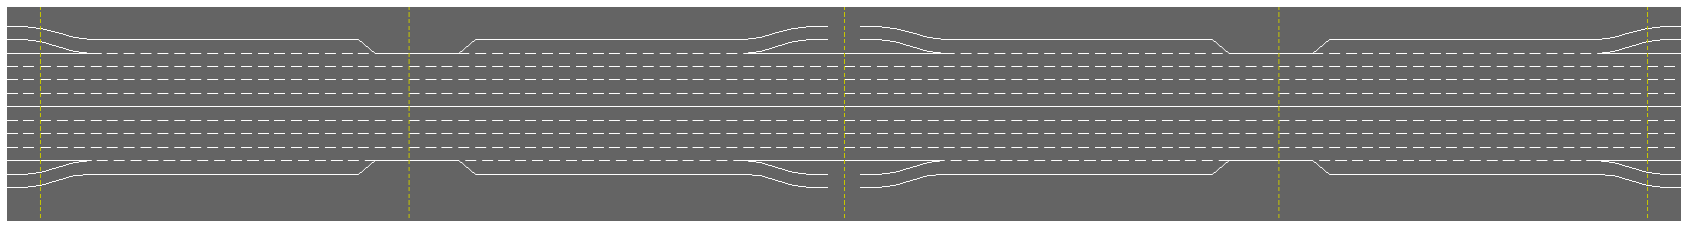

In [7]:
display(env)

# Actions

## Keep Current Lane Configuration

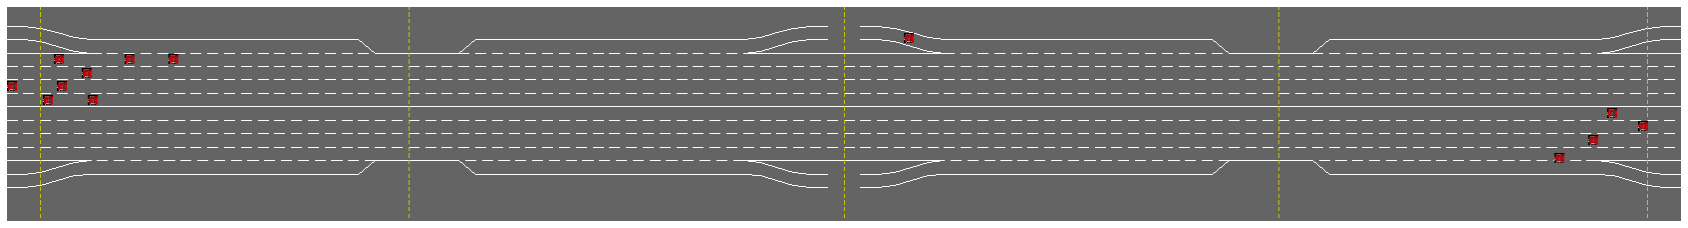

In [9]:
obs = env.reset()
action = env.HOLD
obs, reward, done, info = env.step(action)
display(env)

## Add Lane in Upstream Direction

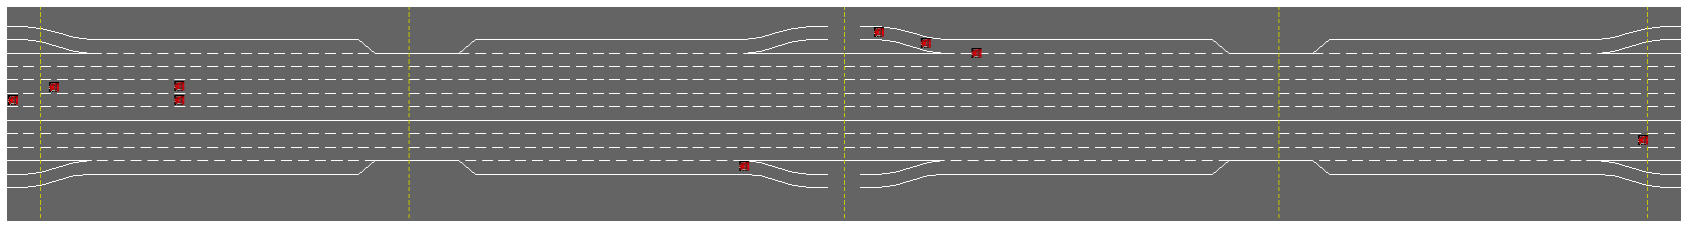

In [5]:
obs = env.reset()
action = env.ADD_UPSTREAM
obs, reward, done, info = env.step(action)
display(env)

## Add Lane in Downstream Direction

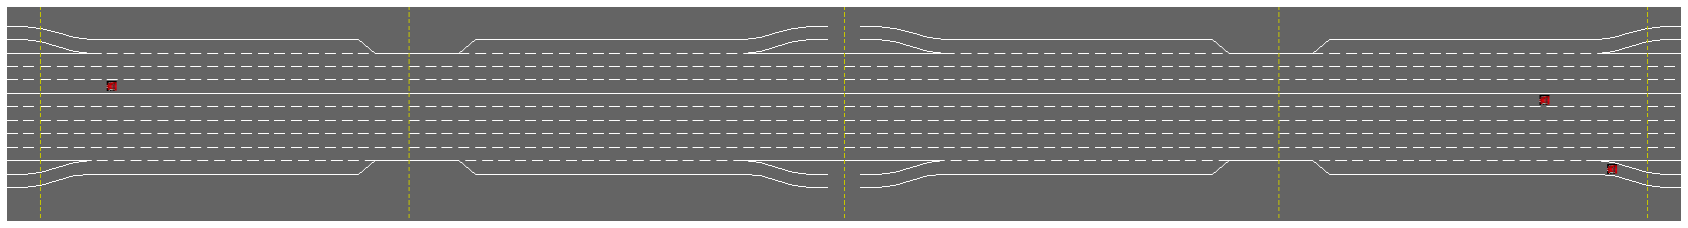

In [8]:
obs = env.reset()
action = env.ADD_DOWNSTREAM
obs, reward, done, info = env.step(action)
display(env)

# State

In [18]:
obs = env.reset()
obs

array([0.5, 0. , 0. , 0. ])

In [17]:
obs = env.reset()
for i in range(5):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(f'State for step {i}:\nLanes Ratio: {obs[0]}\nSpeed Imbalance: {round(obs[1],2)}\nDensity Imbalance: {round(obs[2],2)}\nFlow Imbalance: {round(obs[3],2)}\n')

State for step 0:
Lanes Ratio: 0.5
Speed Imbalance: 0.01
Density Imbalance: 0.0
Flow Imbalance: 0.0

State for step 1:
Lanes Ratio: 0.625
Speed Imbalance: -0.0
Density Imbalance: -0.05
Flow Imbalance: 0.43

State for step 2:
Lanes Ratio: 0.75
Speed Imbalance: -0.01
Density Imbalance: -0.12
Flow Imbalance: 0.44

State for step 3:
Lanes Ratio: 0.625
Speed Imbalance: -0.04
Density Imbalance: 0.43
Flow Imbalance: 0.47

State for step 4:
Lanes Ratio: 0.75
Speed Imbalance: -0.05
Density Imbalance: 0.31
Flow Imbalance: 0.81



# Reward

In [23]:
obs = env.reset()
for i in range(5):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(f'Step {i}: Action: {action}, Reward: {reward}')

Step 0: Action: 0, Reward: 0
Step 1: Action: 1, Reward: -0.5108695652173914
Step 2: Action: 2, Reward: 0.25
Step 3: Action: 0, Reward: 0.1
Step 4: Action: 2, Reward: -1.0


# Baseline Models

In [9]:
model = NoneAgent(env)
obs, done = env.reset(), False
env.frames = []

cum_reward = 0

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render(mode = 'rgb_array')
    cum_reward += reward

print(f'Total Reward: {cum_reward}')
results = env.evaluate
history_df = env.history

env.close()

history_df.to_csv('baseline1.csv', index=False)

Total Reward: -41.86987452797601


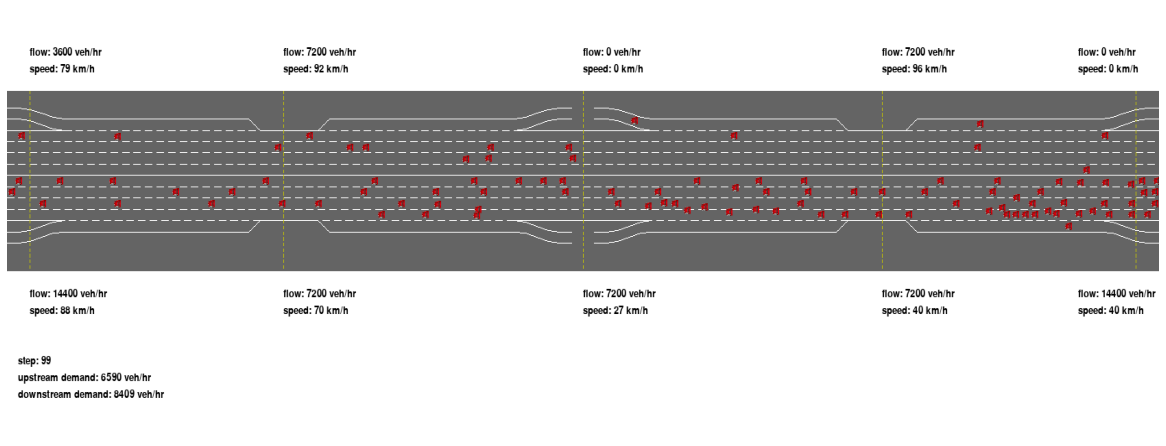

In [10]:
save_gif(env.frames, 'baseline1.mp4')

In [54]:
print(f'Average Travel Time = {round(results["average_travel_time"], 2)} seconds')
print(f'Average Deviation From Free-flow Speed = {round(results["average_deviation_from_free_flow_speed_kmh"],2)} km/h')
print(f'Total Throughput = {results["total_throughput"]}')

Average Travel Time = 17.42 seconds
Average Deviation From Free-flow Speed = 7.89 km/h
Total Throughput = 228


In [55]:
Video('baseline1.mp4')

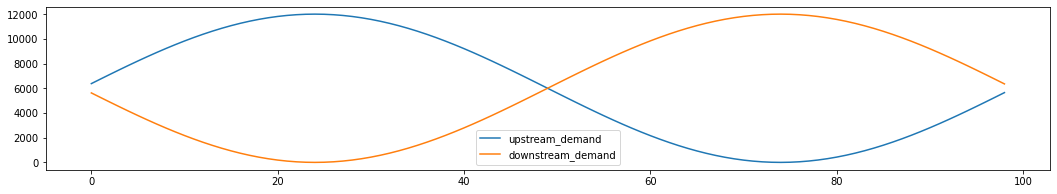

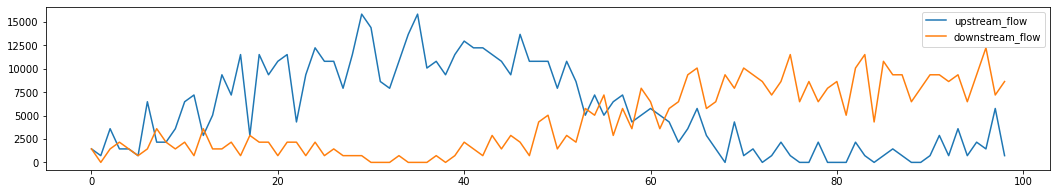

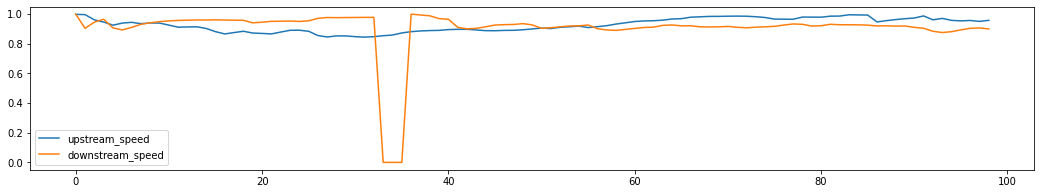

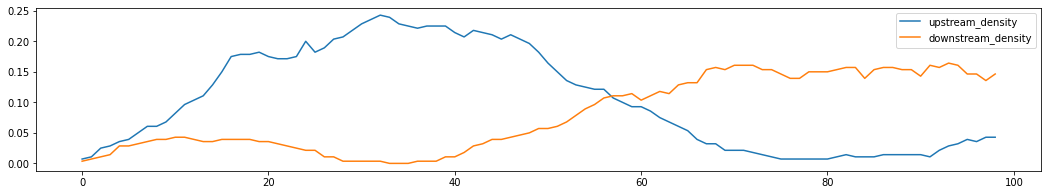

In [5]:
history_df[['upstream_demand', 'downstream_demand']].plot(figsize=(18,3));
history_df[['upstream_flow', 'downstream_flow']].plot(figsize=(18,3));
history_df[['upstream_speed', 'downstream_speed']].plot(figsize=(18,3));
history_df[['upstream_density', 'downstream_density']].plot(figsize=(18,3));

In [7]:
model = HeuristicAgent(env)
obs, done = env.reset(), False
env.frames = []
cum_reward = 0

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render(mode = 'rgb_array')
    cum_reward += reward

print(f'Total Reward: {cum_reward}')
results = env.evaluate
history_df = env.history

env.close()

history_df.to_csv('baseline3.csv', index=False)

Total Reward: -52.673480722629535


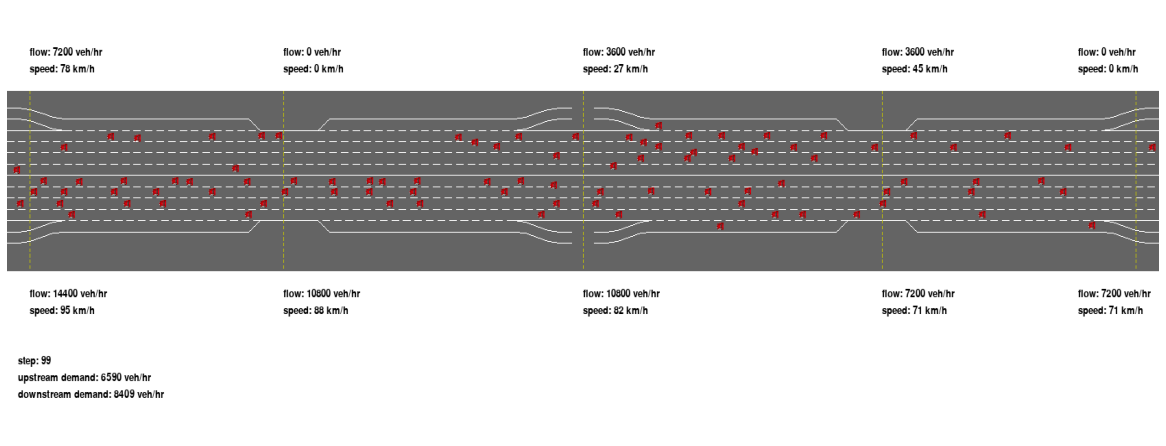

In [8]:
save_gif(env.frames, 'baseline3.mp4')

In [8]:
print(f'Average Travel Time = {round(results["average_travel_time"], 2)} seconds')
print(f'Average Deviation From Free-flow Speed = {round(results["average_deviation_from_free_flow_speed_kmh"],2)} km/h')
print(f'Total Throughput = {results["total_throughput"]}')

Average Travel Time = 17.93 seconds
Average Deviation From Free-flow Speed = 9.44 km/h
Total Throughput = 279


In [ ]:
Video('baseline3.mp4')

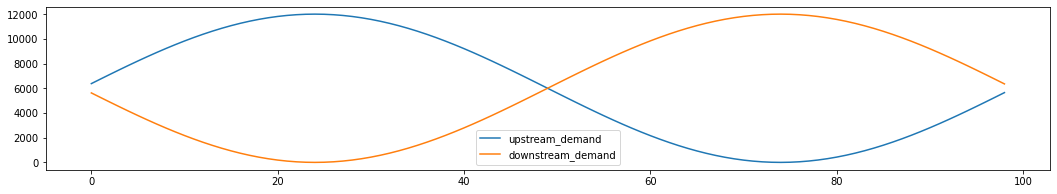

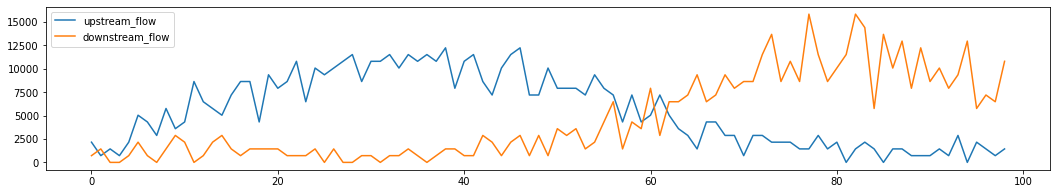

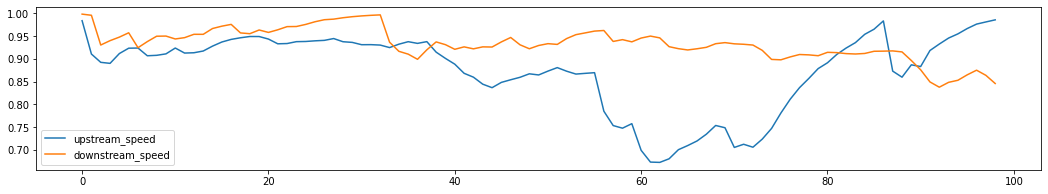

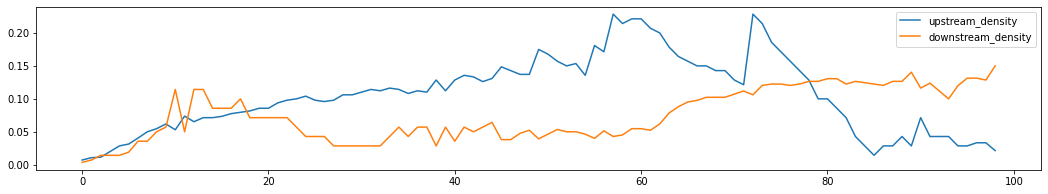

In [7]:
history_df[['upstream_demand', 'downstream_demand']].plot(figsize=(18,3));
history_df[['upstream_flow', 'downstream_flow']].plot(figsize=(18,3));
history_df[['upstream_speed', 'downstream_speed']].plot(figsize=(18,3));
history_df[['upstream_density', 'downstream_density']].plot(figsize=(18,3));

# Deep-Q Learning Model

In [4]:
MODEL_PATH = 'models/dqn_model'
model = DQN.load(MODEL_PATH)

obs, done = env.reset(), False
env.frames = []

cum_reward = 0

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render(mode = 'rgb_array')
    cum_reward += reward

print(f'Total Reward: {cum_reward}')
results = env.evaluate
history_df = env.history

env.close()

history_df.to_csv('dqn_model.csv', index=False)

Total Reward: -7.905384406960351


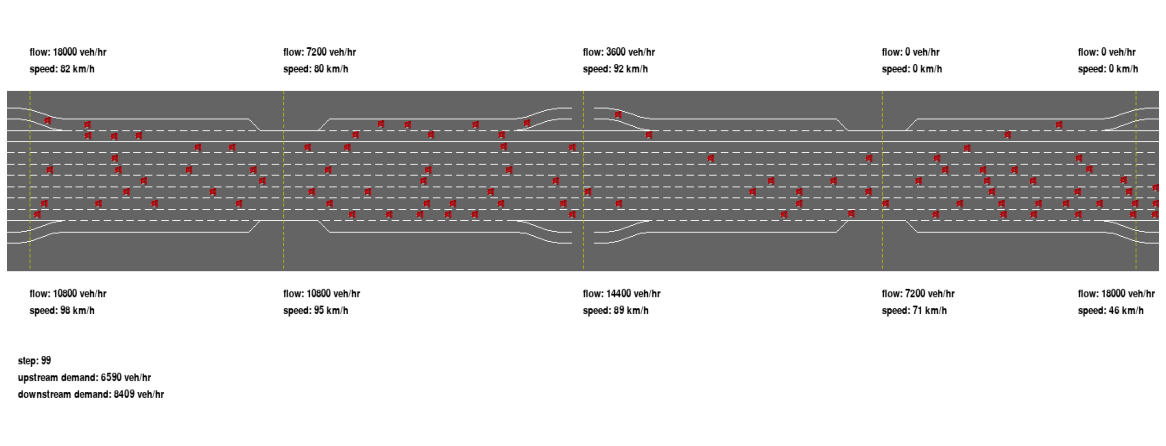

In [5]:
save_gif(env.frames, 'dqn_model_1.mp4')

In [12]:
print(f'Average Travel Time = {round(results["average_travel_time"], 2)} seconds')
print(f'Average Deviation From Free-flow Speed = {round(results["average_deviation_from_free_flow_speed_kmh"],2)} km/h')
print(f'Total Throughput = {results["total_throughput"]}')

Average Travel Time = 18.23 seconds
Average Deviation From Free-flow Speed = 9.82 km/h
Total Throughput = 327


In [6]:
Video('dqn_model_1.mp4')

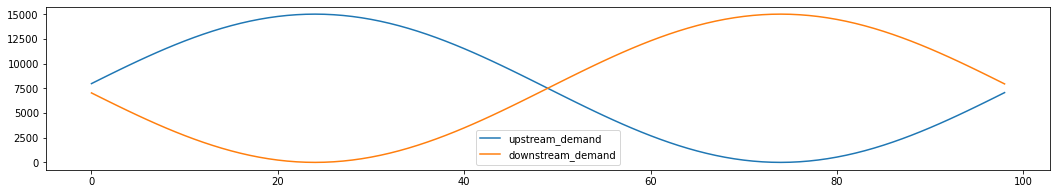

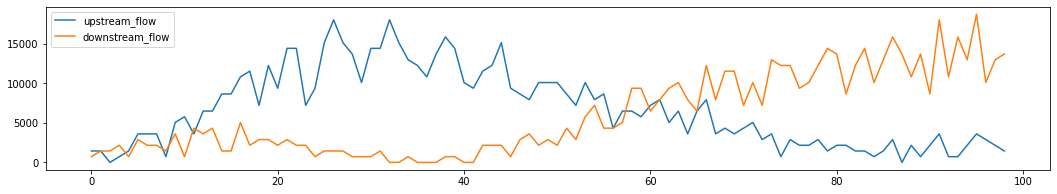

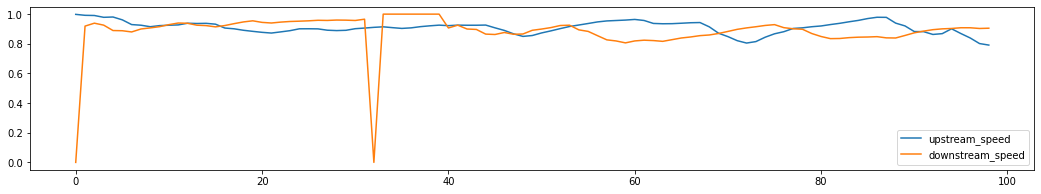

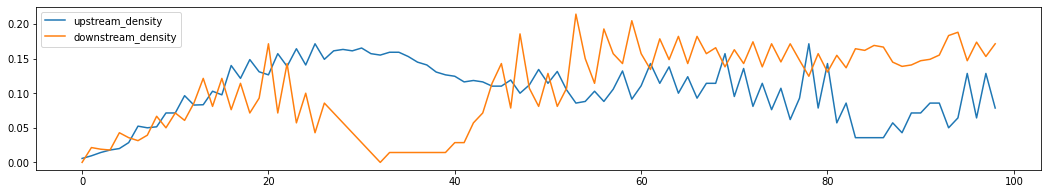

In [14]:
history_df = pd.read_csv('dqn_model.csv')
history_df[['upstream_demand', 'downstream_demand']].plot(figsize=(18,3));
history_df[['upstream_flow', 'downstream_flow']].plot(figsize=(18,3));
history_df[['upstream_speed', 'downstream_speed']].plot(figsize=(18,3));
history_df[['upstream_density', 'downstream_density']].plot(figsize=(18,3));